<a href="https://colab.research.google.com/github/aMurryFly/Text-Classification-AI-Model-on-COVID-19-Tweets/blob/main/FinalProject_TwittClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project of APIT Course
## Data Analysis and Text Classification AI Model on COVID-19 Tweets

###(Análisis y Procesamiento Inteligente de textos)

**Professor:**
- Octavio Augusto Sánchez Velázquez

**Students:**
- Alfonso Murrieta Villegas
- Edgar Michael Pérez Valdez


# 0. Aspectos generales 


## 0.0 Importación de bibliotecas y recursos para el análisis de datos en la etapa de pre-procesamiento

In [1]:
#Bibliotecas generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

# Para la construcción del módelo
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats


In [2]:
# Azúcar visual 
import warnings
warnings.filterwarnings('ignore')

#Para dar formato a los dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 0.1 Importando  y conociendo el dataset

### 0.1.0 Importando datos 

In [3]:
#test=pd.read_csv("/content/DataSet/Corona_NLP_test.csv",encoding='latin1')
#train=pd.read_csv("/content/DataSet/Corona_NLP_train.csv",encoding='latin1')
urlTrain = 'https://raw.githubusercontent.com/aMurryFly/Text-Classification-AI-Model-on-COVID-19-Tweets/main/dataSet/Corona_NLP_train.csv'
urlTest = 'https://raw.githubusercontent.com/aMurryFly/Text-Classification-AI-Model-on-COVID-19-Tweets/main/dataSet/Corona_NLP_test.csv'

test=pd.read_csv(urlTrain,encoding='latin1')
train=pd.read_csv(urlTest,encoding='latin1')


Conociendo nuestros datos para el "test" del futuro módelo

In [4]:
test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test.shape[0]

41157

Conociendo nuestros datos para el "train" del futuro módelo

In [6]:
train.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
train.shape[0]

3798

### 0.1.1 Relación Train y Test Data

Observando relación del dataset de "train y test"

**NOTA**: Para nuestra futura construcción del modelo de AI emplearemos una relación de 75 / 25 como típica convención 

In [8]:
totalData = train.shape[0] + test.shape[0]
print("Total de datos (filas)", totalData)
print("Relación del train respecto al total: ",train.shape[0]/totalData)
print("Relación del test respecto al total: ",test.shape[0]/totalData)

Total de datos (filas) 44955
Relación del train respecto al total:  0.08448448448448448
Relación del test respecto al total:  0.9155155155155155


### 0.1.2 Valores Nulos

Conociendo valores nulos en el dataset

NOTA: Se unieron los datos previamente para conocer la información global

In [9]:
concData=pd.concat([train,test])

nullValues= concData.isnull().sum().sort_values(ascending=False)
total =concData.shape[0]

percent_missing= (concData.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])

Imprimimos los datos obtenidos tras la concatenación de ambos dataframes

In [10]:
print (loss_data)

               Datos nulos  Porcetaje
Location              9424   0.209632
Sentiment                0   0.000000
OriginalTweet            0   0.000000
TweetAt                  0   0.000000
ScreenName               0   0.000000
UserName                 0   0.000000


**NOTA:** Podemos observar que hay una cantidad considerable de datos nulos en la columna de "location", sin embargo, para nuestro modelo no será necesaria esa información.

### 0.1.3 Relación tweets / usuarios 

Al tomar una muestra lo recomendable es no sesgar la información como puede ser el caso de recopilar la información de una misma fuente, es decir, hacer un muestreo aleatorio

Por lo que a continuación se verifica la realación tweets - usuarios (QUe tantos tweets pertenecen a un usuario)

In [11]:
print('Total de tweets: ', concData.shape[0])
print('Total de usuarios (Sin repetir alguno): ', concData['UserName'].nunique())

Total de tweets:  44955
Total de usuarios (Sin repetir alguno):  44955


**NOTA**: Podemos observar que no existe más de un tweet por usuario

# 1. Análisis de datos y conjeturas

**NOTA**

Para el análisis de datos y la construcción del modelo de AI de clasificación de Tweets fue necesario cambiar la cantidad de etiquetas dentro de la clasificación de tweets 

```python
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
```
a

```python
['Neutral' 'Positive' 'Negative' ]
``` 
Donde los casos "extremos" fueron adjuntados en la etiqueta normal, es decir:

'Extremely Negative', 'Negative' => 'Negative'

'Extremely Positive', 'Positive' => 'Positive'

**Justificación:** 

La primera razón del por qué se hará esta recategorización en las etiquetas de sentimal es debido a la complejidad algoritmica y recursos empleados al usar 3 etiquetas en vez de 5.

Y la segunda razón es que encontramos algo subjetivo el decir que un tweet es "extremadamente positivo" o que solamente es "positivo". 


## 1.1 Reetiquetando

Muestreo de datos antes de reetiquetar los datos

In [12]:
print(concData.Sentiment.value_counts())

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


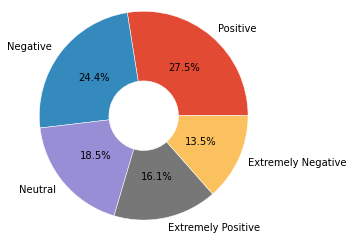

In [13]:
pre_class_allData = concData.groupby('Sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= pre_class_allData.OriginalTweet
labels= pre_class_allData.Sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

Reetiquetando datos

In [14]:
def reetiqueta(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"

In [15]:
dataFrame = concData 
dataFrame['sentiment']= concData['Sentiment'].apply(lambda x:reetiqueta(x))

print("Distribución previa:\n ", concData.Sentiment.value_counts())
print("\n\n\nDistribución actual: \n", dataFrame.sentiment.value_counts())

Distribución previa:
  Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64



Distribución actual: 
 positive    19592
negative    17031
neutral      8332
Name: sentiment, dtype: int64


Nueva distribución de los datos y visualización del nuevo dataFrame

In [16]:
dataFrame.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,neutral


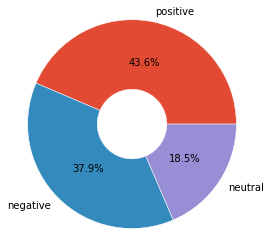

In [17]:
class_allData = dataFrame.groupby('sentiment').count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
percent_class= class_allData.OriginalTweet
labels= class_allData.sentiment

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,autopct="%.1f%%")

plt.setp(my_pie, width=0.8, edgecolor='white') 

plt.show()

## 1.2 Distribución de datos 

### 1.2.1 Carácteres

Gráficas para conocer la distribución dentro de cada clase en la etiqueta de sentimientos

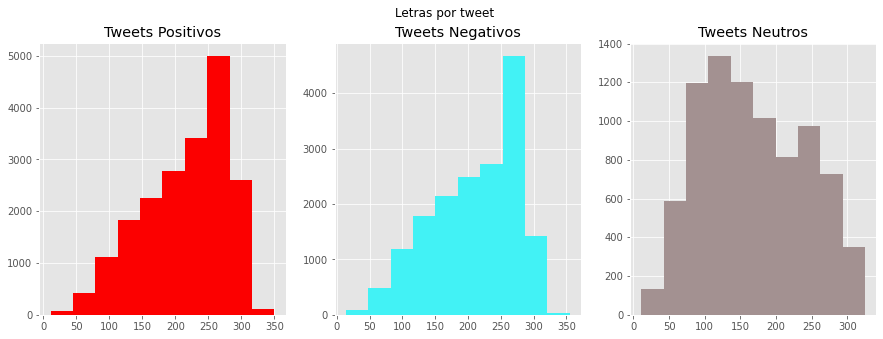

In [18]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_Pos=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.len()
ax1.hist(tweet_Pos,color='#FC0000')
ax1.set_title('Tweets Positivos')

tweet_Neg=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_Neg,color='#42F2F5')
ax2.set_title('Tweets Negativos')

tweet_Null=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_Null,color='#A39191')
ax3.set_title('Tweets Neutros')

fig.suptitle('Letras por tweet')
plt.show()

In [19]:
# Agregando header para medias
#Solo correr una vez
tweet_Pos = tweet_Pos.to_frame('characters') 
tweet_Neg = tweet_Neg.to_frame('characters') 
tweet_Null = tweet_Null.to_frame('characters') 

In [20]:

PosMedia = tweet_Pos['characters'].mean()
NegMedia = tweet_Neg['characters'].mean()
NullMedia = tweet_Null['characters'].mean()

print("Promedio de carácteres en tweets positivos",PosMedia )
print("Promedio de carácteres en tweets negativos",NegMedia )
print("Promedio de caracteres en tweets neutros",NullMedia )

Promedio de carácteres en tweets positivos 215.60090853409554
Promedio de carácteres en tweets negativos 210.87358346544536
Promedio de caracteres en tweets neutros 168.16082573211713


**NOTA:**
Podemos observar a priori que notamos ciertos patrones de asimetría en las respectivas distribuciones, sin embargo, también observamos que el promedio de carácteres en los tweets neutros suele ser mucho menor respecto a la cantidad usada en los tweets positivos y negativos

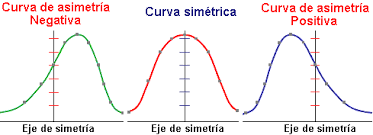

Cabe destacar que este tipo de información es útil sobre todo para crear nuestro futuro modelo de IA 

### 1.2.2 Distribución y promedio de palabras 


(0.0, 20.0)

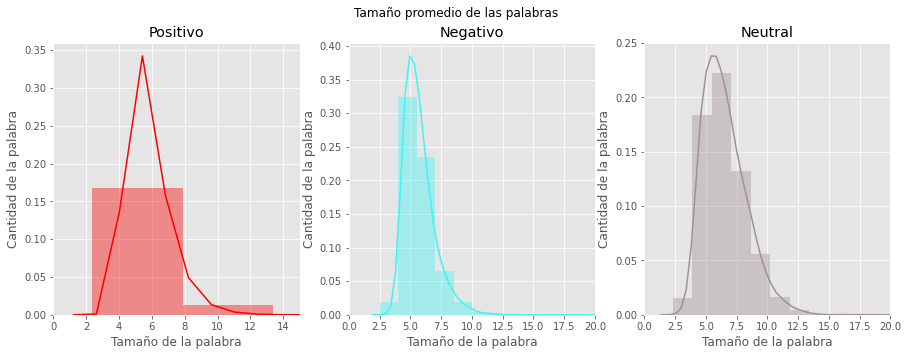

In [21]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Tamaño promedio de las palabras \n')

Pos_words=dataFrame[dataFrame['sentiment']=="positive"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Pos_words.map(lambda x: np.mean(x)),ax=ax1,color='#FC0000')
ax1.set_title('Positivo')
ax1.set_xlabel('Tamaño de la palabra')
ax1.set_ylabel('Cantidad de la palabra')
ax1.set_xlim(0,15)

Neg_word=dataFrame[dataFrame['sentiment']=="negative"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Neg_word.map(lambda x: np.mean(x)),ax=ax2,color='#42F2F5')
ax2.set_title('Negativo')
ax2.set_xlabel('Tamaño de la palabra')
ax2.set_ylabel('Cantidad de la palabra')
ax2.set_xlim(0,20)

Null_word=dataFrame[dataFrame['sentiment']=="neutral"]['OriginalTweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(Null_word.map(lambda x: np.mean(x)),ax=ax3,color='#A39191')
ax3.set_title('Neutral')
ax3.set_xlabel('Tamaño de la palabra')
ax3.set_ylabel('Cantidad de la palabra')
ax3.set_xlim(0,20)

**NOTA 1:**

A priori podemos observar patrones como el que los mensajes neutros de manera general manejan palabras mucho más extensas en cantidad de letras, mientras que los mensajes positivos suelen tener una menor cantidad de letras por palabras,es decir, los mensajes motivadores suelen ser pequeños (Para reafirmar esta hipótesis haremos uso de wordclouds como forma de visualización de las palabras)



**NOTA 2:**

Al igual que en el apartado anterior podemos observar un comportamiento relativamente similar en los tweets neutrales, donde la media de la distribución de las palabras tiende a ser menor respectos a los tweets positivos y negativos.

Por otro lado, podemos llegar a observar nuevamente umna desviación de datos hacia la izquierda , es decir una simetría negativa que probablemente se deba a factores como la cantidad de palabras/carácteres que se puede usar en Twitter 

# 2. Limpieza de datos 

## 2.1 Stopwords 



Función para crear el corpus con el que posteriormente se hará el modelo de AI de clasificación

In [22]:
def create_corpus(target):
    corpus=[]
    
    for x in dataFrame[dataFrame['Sentiment']==target ]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Importanción de bibliotecas y recursos para *tokinaze* y para el uso de NLTK (Previo a la creación del modelo de inteligencia artificial)


In [23]:
import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NOTA**
Haremos uso de *stopwords* para poder omitir las palabras más comúnes del inglés que sin duda no serán necesarias para sacar los patrones de comportamiento de los tweets

**Stopwords** = Palabra comúnmente usada tal como "él, "un" que al ser conectores son omitidos por no aportar información en análisis concretos de textos


In [24]:
np.array(stop)

array({'needn', 'shouldn', "couldn't", 'theirs', 'here', 'out', 'themselves', 'whom', 'him', 'any', 'ma', 'ain', 'should', 'where', "doesn't", 'myself', 'if', 'off', 'then', "hadn't", 'don', "isn't", 'under', "won't", 'll', 'having', 'why', 'y', 'yourselves', 'was', 'she', 'mightn', 'your', 'by', 'with', 'will', 'hasn', 'me', 'do', 'before', "you'd", 'who', 't', 'them', 'how', 'such', 'won', 'has', 'aren', 'what', 'the', "you're", 'too', 'below', 've', 'that', 'being', 'ours', "mightn't", 'wouldn', 'is', 'from', 'of', "she's", 'you', 'now', 'be', 'down', "don't", "should've", 're', 'himself', 'other', "you'll", 'just', 'does', 'a', 'there', 'isn', 'after', 'shan', "wasn't", 'over', 'while', 'we', 'so', 'in', 'have', 'up', 'mustn', 'am', "didn't", 'few', "it's", 'can', 'my', 'were', "aren't", 'are', 'during', 'on', 'most', 'which', "mustn't", 'couldn', 'again', 'and', 'into', 'itself', 'as', "shan't", 'at', 'only', 'herself', 'than', 'because', 'wasn', 'when', 'ourselves', "needn't", 't

## 2.2 Limpieza de datos y separación de datos respecto al sentimiento

Función para remover links

In [25]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

Función para hacer todas las letras en minúsculas

In [26]:
def turn_lower(text):
    low_text= text.lower()
    return low_text

Función para remover stopwords

In [27]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [28]:
#Agrgamos estos 2 debido a que son la basura que dejan los emojis al hacerse texto plano
STOPWORDS.add("amp")
STOPWORDS.add("??")

LLamada de todas las funciones en el dataFrame

In [29]:
dataFrame['Clean_Tweet']=dataFrame['OriginalTweet'].apply(lambda x:remove_urls(x))
dataFrame['OriginalTweet']=dataFrame['Clean_Tweet'].apply(lambda x:remove_stopwords(x))
dataFrame['Clean_Tweet']=dataFrame['OriginalTweet'].apply(lambda x:turn_lower(x))
dataFrame[10:15]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,Clean_Tweet
10,11,44963,"Boksburg, South Africa",04-03-2020,Best quality couches unbelievably low prices a...,Positive,positive,best quality couches unbelievably low prices a...
11,12,44964,New Delhi,04-03-2020,Beware counterfeits trying sell fake masks che...,Extremely Negative,negative,beware counterfeits trying sell fake masks che...
12,13,44965,"USA, PA",04-03-2020,Panic food buying Germany due #coronavirus beg...,Extremely Negative,negative,panic food buying germany due #coronavirus beg...
13,14,44966,NaN,04-03-2020,"#Covid_19 Went Grocery Store, turns cleaning s...",Extremely Positive,positive,"#covid_19 went grocery store, turns cleaning s..."
14,15,44967,"Washington, DC",04-03-2020,While busy watching election returns bracing C...,Positive,positive,while busy watching election returns bracing c...


Funciones para remover hastags y etiquetados 

In [30]:
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

Observamos como ha quedado el dataframe tras la limpieza de los tweets

In [31]:
dataFrame['OriginalTweet']=dataFrame['Clean_Tweet'].apply(lambda x:remove_hash(x))
dataFrame['Clean_Tweet']=dataFrame['OriginalTweet'].apply(lambda x:remove_mention(x))
dataFrame[10:15]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,Clean_Tweet
10,11,44963,"Boksburg, South Africa",04-03-2020,best quality couches unbelievably low prices a...,Positive,positive,best quality couches unbelievably low prices a...
11,12,44964,New Delhi,04-03-2020,beware counterfeits trying sell fake masks che...,Extremely Negative,negative,beware counterfeits trying sell fake masks che...
12,13,44965,"USA, PA",04-03-2020,panic food buying germany due begun. but lef...,Extremely Negative,negative,panic food buying germany due begun. but lef...
13,14,44966,NaN,04-03-2020,"went grocery store, turns cleaning supplies b...",Extremely Positive,positive,"went grocery store, turns cleaning supplies b..."
14,15,44967,"Washington, DC",04-03-2020,while busy watching election returns bracing c...,Positive,positive,while busy watching election returns bracing c...


Válidamos si no hay algún tweet que se haya vuelto nulo respecto al contenido del tweet que ahora se encuentra en la columna 'text_new'

In [32]:
nullValues= dataFrame.isnull().sum().sort_values(ascending=False)
total =dataFrame.shape[0]

percent_missing= (dataFrame.isnull().sum()/total).sort_values(ascending=False)
loss_data= pd.concat([nullValues, percent_missing], axis=1, keys=['Datos nulos', 'Porcetaje'])
print(loss_data)

               Datos nulos  Porcetaje
Location              9424   0.209632
Clean_Tweet              0   0.000000
sentiment                0   0.000000
Sentiment                0   0.000000
OriginalTweet            0   0.000000
TweetAt                  0   0.000000
ScreenName               0   0.000000
UserName                 0   0.000000


In [33]:
dataFramePos = dataFrame[dataFrame["sentiment"]=="positive"]
dataFrameNeg = dataFrame[dataFrame["sentiment"]=="negative"]
dataFrameNeu = dataFrame[dataFrame["sentiment"]=="neutral"]
dataFramePos.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,Clean_Tweet
1,2,44954,"Seattle, WA",02-03-2020,"when i find hand sanitizer fred meyer, i turne...",Positive,positive,"when i find hand sanitizer fred meyer, i turne..."
2,3,44955,NaN,02-03-2020,find protect loved ones . ?,Extremely Positive,positive,find protect loved ones . ?
6,7,44959,NaN,03-03-2020,voting age = hand sanitizer ?,Positive,positive,voting age = hand sanitizer ?


## 2.3 WordCloud y visualización de palabras por sentimientos

Función para generar los bagwords empleados en los wordclouds

In [34]:
def bagWords(x):
  comment_words = '' 
  stopwords = set(STOPWORDS) 

  for val in x.Clean_Tweet: 
      val = str(val) 
      tokens = val.split() # split the value 
      comment_words += " ".join(tokens)+" "
  return comment_words

**Word Cloud del DataFrame Positivo**

Se pueden observar las palabras más comúnes en los tweets positivos

In [35]:
bagwordsvar = bagWords(dataFramePos)
#bagwordsvar

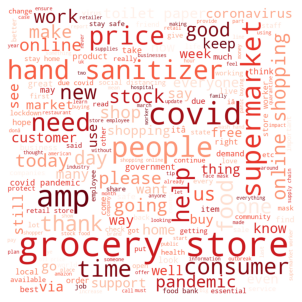

In [36]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                min_font_size = 10).generate(bagwordsvar)
                       
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()   

**Word Cloud del DataFrame Negativos**

Se pueden observar las palabras más comúnes en los tweets negativos

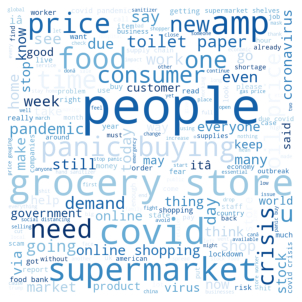

In [37]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Blues",
                min_font_size = 10).generate(bagWords(dataFrameNeg))
                      
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

**Word Cloud del DataFrame Neutro**

Se pueden observar las palabras más comúnes en los tweets neutro

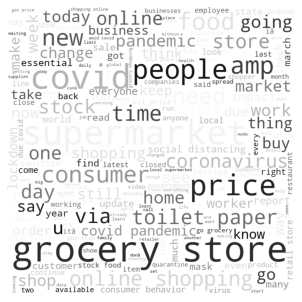

In [38]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                min_font_size = 10).generate(bagWords(dataFrameNeu))
                                      
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show() 

**Conjeturas basadas en los wordclouds:**

Lo primero que podemos observar patrones diferenciales entre los mensajes positivos y negativos respecto a los neutros como:

1. Uso de palabras para hacer referenciar o argumentar el contexto de los mensajes es el caso de "said", "report", "update"

2. En el caso de los tweets positivos y negativos vemos palabras como es el caso de "*pandemic*" (en el caso negativo) o "*help*" o "*hand*" (en el caso positivo)

**NOTA:**

Con base en todas las conjeturas de comportamiento de las palabras respecto a los sentimientos es como haremos la decisión de un modelo que se adecue al tipo de problemática, además de considerar variables específicas al construir nuestro modelo de AI 


# 3. Contruyendo el modelo de IA para clasificar
 

## 3.1  Separación de datos y pre procesado para el modelo

In [39]:
dataFrame.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,sentiment,Clean_Tweet
0,1,44953,NYC,02-03-2020,trending: new yorkers encounter empty supermar...,Extremely Negative,negative,trending: new yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",02-03-2020,"when i find hand sanitizer fred meyer, i turne...",Positive,positive,"when i find hand sanitizer fred meyer, i turne..."
2,3,44955,NaN,02-03-2020,find protect loved ones . ?,Extremely Positive,positive,find protect loved ones . ?


Seperación de los datos en Train y Test para el entrenamiento y prueba del modelo 

In [40]:
X = dataFrame["Clean_Tweet"].copy()
y = dataFrame["sentiment"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

Etapa de "Tokenizing" para poder meter bagwords dentro de nuestro modelos

In [41]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index)
X = pad_sequences(X, padding='post')

print("Cantidad de palabras: ", vocab_size)

print("\nTexto original: ", X_train[6], "\n\n")
print("Texto después del tokenizing: \n", X[2])


Cantidad de palabras:  34312

Texto original:  cashier grocery store sharing insights  to prove credibility commented "i'm civics class i know i'm talking about". 


Texto después del tokenizing: 
 [136  11 834 253   2   1 350 310   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Cambiamios las clases a valores numéricos discretos (Esto debido a que es la forma en la que trabaja la entrada de datos del modelo)

In [42]:
labels = ['negative', 'neutral', 'positive']
re_classes = {'negative': 0,
            'neutral': 1,
            'positive':2,
           }
           
y.replace(re_classes, inplace=True)

In [43]:
y.head(2)

0    0
1    2
Name: sentiment, dtype: int64

## 3.2 Construcción del modelo (Etapa de entrenamiento)

### 3.2.0 Aspectos generales

Bibliotecas para el modelo

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

Variables globales para el manejo del modelo:
Referencia:
[towardsdatascience](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

In [45]:
tf.keras.backend.clear_session()

EPOCHS = 100
BATCH_SIZE = 32
embedding_dim = 16
units = 256

### 3.2.1 Construcción del modelo

**NOTA**

Para este problema decidimos emplear una Red Neuronal del tipo **RNN**, específicamente del tipo **LSTM**  (Long Short Term Memory)

In [46]:
model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

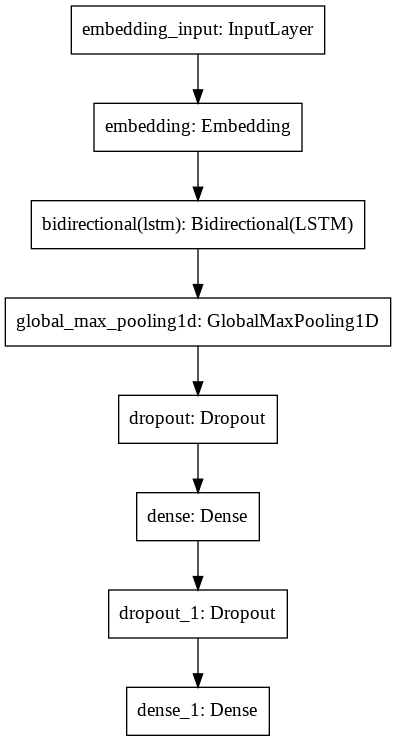

In [47]:
tf.keras.utils.plot_model(model)

### 3.2.2 Entrenamiento del modelo 

**Nota:** 
Recordemos que el accuracy o precisión del módelo lo obtendremos sobre todo en la parte del test 

In [ ]:
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/100
828/928 [=========================>....] - ETA: 1s - loss: 1.0469 - accuracy: 0.4145

## 3.3 Prueba del modelo "Test"

Renombrando las clases en los datos de prueba

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(re_classes, inplace=True)

Probando el modelo

In [ ]:
pred = model.predict_classes(X_test)

In [ ]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss (Perdida): ', loss)
print("Test Accuracy (Precisión):", acc)

## 3.4 Validación y estadística del modelo


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()


**Matriz de Confusión** para falsos positivos y casos reales

In [ ]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## 3.5 Prueba de casos particulares

**NOTA: **

Cabe destacar que el mostrar casos particulares no es significativo estadísticamente hablando, sin embargo, es una demostración totalmente visible al consumidor

In [ ]:
dataFrame.head(1)

In [ ]:
# La columna 7 es la de Clean_tweet
string = dataFrame.iloc[0, 7]
string